### NOTE:

To run this notebook by loading the extracted features and pre-trained weights, specify the following flags as True.
- load_features = True
- load_weights = True

When these flags are true, this notebook will take at most 3 minutes to run.

In [1]:
load_features = True
load_weights = True

# Assignment I: CS776A - Deep Learning for Computer Vision
# Question (100 Marks)
### In this assignment, your goal is to implement and train a multi-layer perceptron (MLP) on the CIFAR10 dataset with data augmentation (Single hidden layer with 64 neurons MLP model).


### Importing necessary libraries

In [2]:
import cv2
import math
import tarfile
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from codefiles import feature_extractor

## 1. Download the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). Hint: Use pickle library to load the dataset. [5 marks]

In [3]:
def unpickle(file):
    '''
    The unpickle function loads data from the input pickle files
    '''
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot_encode(data, n_classes):
    '''
    Parameters
    ----------
    data : np.array
        numerical data denoting the class of input
    n_classes: int
        number of classes in the dataset
    Returns
    -------
    encoded_labels: np.array
        one_hot_encoded labels
    Example
    -------
    If the input is [0, 2, 3, 1], the one_hot_encoded output will be
    [[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0]]
    '''
    
    encoded_labels = np.zeros((len(data), n_classes))
    for i, x in enumerate(data):
        encoded_labels[i][x] = 1
    
    return encoded_labels

def load_cifar10(filepath):
    '''
    This function loads the CIFAR10 data and returns the following:
        train_data: (50000, 3, 32, 32) numpy array consisting of training images
        train_labels: (50000, 10) numpy array consisting of one_hot_encoded labels
        test_data: (10000, 3, 32, 32) numpy array consisting of test data images
        test_labels: (10000, 10) numpy array consisting of one_hot_encoded labels
    '''
    
    # Extract the tar file
    tar = tarfile.open(filepath, "r:gz")
    tar.extractall()
    tar.close()
    
    # Load the metadata using unpickle
    batches_meta = unpickle('cifar-10-batches-py/batches.meta')

    # Extract the label_names from the metadata dictionary
    label_names = batches_meta[b'label_names']

    # Load all the five training batches and test batch using unpickle
    for i in range(1, 6):
        data_batch = unpickle('cifar-10-batches-py/data_batch_'+str(i))
        if i==1:
            train_data = np.array(data_batch[b'data'])
            train_labels = np.array(data_batch[b'labels'])
        else:
            train_data = np.vstack((train_data, data_batch[b'data']))
            train_labels = np.concatenate([train_labels, data_batch[b'labels']])
    test_data = unpickle('cifar-10-batches-py/test_batch')[b'data']
    test_labels = unpickle('cifar-10-batches-py/test_batch')[b'labels']
    
    # Reshape the train and test data
    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    # OneHotEncode the train and test labels
    train_labels = one_hot_encode(train_labels, 10)
    test_labels = one_hot_encode(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

In [4]:
# Load train and test data of CIFAR10
unaugmented_train_data, unaugmented_train_labels, test_data, test_labels = load_cifar10('cifar-10-python.tar.gz')

## 2. Implement the image transformation methods mentioned below: [5x4=20 marks]

## (a) Random Rotation in the range [−180◦, 180◦]

In [5]:
def random_rotation(img):
    '''
    This function performs random rotation in the range [−180◦, 180◦]
    '''
    
    height, width, channels = img.shape[0], img.shape[1], img.shape[2]
    
    # Select a random angle value between -180 to 180 degrees and convert it into radians  
    angle = math.radians(random.randint(-180, 180))
    
    # Calculate sine and cosine of the angle
    sin, cos = math.sin(angle), math.cos(angle)
    
    # Create an empty matrix of similar size to store the rotated image
    out = np.zeros_like(img)
    
    # Find the location of center pixel in the image
    center = int(height/2)
    
    for i in range(height):
        for j in range(width):
            
            # Calculate the new pixel location using the following formula:
            # new_height = -x*sin + y*cos
            # new_width = x*cos + y*sin
            pixel_location_modified = int(-(height-center-j-1)*sin + (height-center-i-1)*cos) , int((height-center-j-1)*cos + (height-center-i-1)*sin)   
            pixel_location_modified = center - pixel_location_modified[0], center - pixel_location_modified[1]
            
            # If the modified pixel location lies within the range then assign the pixel value from the input image, else leave it as 0
            if 0 <= pixel_location_modified[0] < height and 0 <= pixel_location_modified[1] < width and pixel_location_modified[0] >= 0 and pixel_location_modified[1] >= 0:
                out[pixel_location_modified[0], pixel_location_modified[1], :] = img[i, j, :] 

    return out

## (b) Random cutout (randomly erase a block of pixels from the image with the width and height of the block in the range 0 to 16 pixels. The erased part (cutout) should be filled with a single value)

In [6]:
def random_cutout(img):
    '''
    This function performs random cutout in the image. The cutout block has height and width
    randomly chosen between the range [0, 16] pixels and it is filled with 0.
    '''
    
    height, width, channels = img.shape[0], img.shape[1], img.shape[2]
    
    new_img = img.copy()
    
    # Chose a random number for width and height of the cutout
    cutout_height, cutout_width = random.randint(0, 16), random.randint(0, 16)
    
    # Chose a random location which would be the top-left corner of the cutout
    top_left_height, top_left_width = random.randint(0, height-cutout_height), random.randint(0, width-cutout_width)
    
    # Assign value 0 to the pixels that lie within the cutout region
    for i in range(top_left_height, top_left_height+cutout_height):
        for j in range(top_left_width, top_left_width+cutout_width):
            new_img[i, j, :] = 0
        
    return new_img

## (c) Random Crop (Add a padding of 2 pixels on all sides and randomly select a block of 32x32 pixels from the padded image)

In [7]:
def random_crop(img):
    '''
    This function performs random crop in the image. The image is first padded with 2 pixels
    on all sides, then a random block of 32x32 size is selected.
    '''
    
    height, width, channels = img.shape[0], img.shape[1], img.shape[2]
    
    # Create an output matrix with 4 pixels extra for height and width
    out = np.zeros((height+4, width+4, channels), dtype=np.uint8)
    
    # Assign the input image to this 'out' matrix to construct a 2-pixel padded image
    out[2:2+height, 2:2+width, :] = img
    
    # Select the top_left_corner randomly
    top_left_corner = random.randint(0, 4), random.randint(0, 4)
    
    # Return the image of shape 32x32 selected from the above chosen top_left_corner
    return out[top_left_corner[0]:top_left_corner[0]+height, top_left_corner[1]:top_left_corner[1]+width]

## (d) Contrast & Horizontal flipping. (First, change the contrast of the image with a factor of α randomly selected from the range (0.5, 2.0) and then flip the image horizontally with a probability of 0.5)

### Instructions for changing contrast of an image:

Given an image x with pixel values in range [0, 255], you can change its contrast by a factor of α using the following steps:

i. Change all the pixel values with formula x′(i, j, c) = α·(x(i, j, c)−128)+128. Here, x(i, j, c) refers to the c-th channel value of the (i, j)-th pixel.

ii. Clip the pixel values in x′ so that the final values are in the range [0, 255]

Note that α < 1 will decrease the contrast of the image while α > 1 will increase the
contrast.

In [8]:
def contrast_and_horizontal_flip(img):
    
    '''
    This function changes the contrast of the image based on randomly selected alpha
    and then flips the image horizontally with a probability of 0.5
    '''
    
    # Select a random alpha in the range [0.5, 2.0]
    alpha = random.uniform(0.5, 2.0)

    # Copy the image to an out variable and convert float values to int
    out = img.copy()
    out = np.float32(out)

    # Apply the contrast based on given formula
    out = alpha*(out-128) + 128
    
    # Clip the values within the range of 0-255
    out[out < 0], out[out > 255] = 0, 255
    
    # Horizontal flip with a probability 0.5.
    # Select a random number between 0 and 1, and if the number is 1 then do horizontal flip
    if(random.randint(0, 1) == 1):
        out = out[:, ::-1, :]  # Keep the channels and height same, but flip the width
    
    # Return the output image as int type, similar to the original dataset
    out = np.uint8(out)
    
    return out

### Test the above transformations on few random samples from the training data

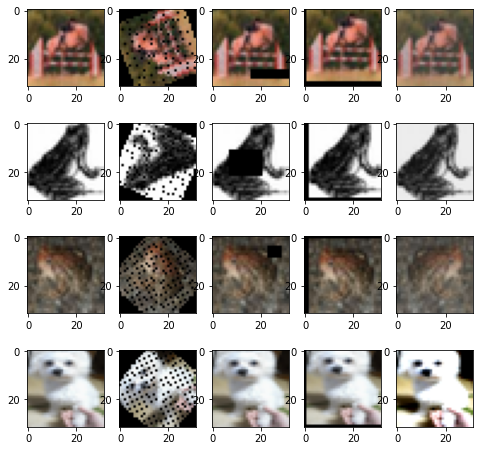

In [9]:
# Test the above transformation functions
fig = plt.figure(figsize=(8, 8))
rows, cols = 4, 5
samples = unaugmented_train_data[np.random.randint(0, len(unaugmented_train_data), 4)]  # Select 4 random samples

# For each of the 4 samples, display its transformed version in the plot
j = 1
for i in range(len(samples)):
    
    img = np.transpose(samples[i], (1, 2, 0))  # Transpose the image so that channels are at the end
    
    fig.add_subplot(rows, cols, j)
    plt.imshow(img)
    j += 1
    
    fig.add_subplot(rows, cols, j)
    plt.imshow(random_rotation(img))
    j += 1
    
    fig.add_subplot(rows, cols, j)
    plt.imshow(random_cutout(img))
    j += 1
    
    fig.add_subplot(rows, cols, j)
    plt.imshow(random_crop(img))
    j += 1
    
    fig.add_subplot(rows, cols, j)
    plt.imshow(contrast_and_horizontal_flip(img))
    j += 1
    
plt.show()

## 3. Create the augmented training set using the transformation functions implemented in the previous part. Randomly select one of the four transformations for each image in the training set and apply it to that image. Combine the transformed images with original training set to get the augmented training set. Note that the number of examples for the augmented training set will be twice that of the unaugmented training set. [10 marks]

In [10]:
def augment_data(train_data):
    '''
    The following function augments the training data with the
    additional transformed images.
    '''
    
    # We create an array to store the transformed images
    transformed_train_data = np.zeros((len(train_data), 3, 32, 32))
    
    # Iterate over the images in training data and update our transformed_train_data array
    for i in range(len(train_data)):
        
        # Choose a random number between 0-3 and apply one of the transformation
        r = random.randint(0, 3)
        
        # Shift image channels to the end so that image shape is now (32, 32, 3)
        x = np.transpose(train_data[i], (1, 2, 0))
        
        if(r==0):
            out = random_rotation(x)
        elif(r==1):
            out = random_cutout(x)
        elif(r==2):
            out = random_crop(x)
        else:
            out = contrast_and_horizontal_flip(x)
        
        # Shift image channels to the start so that image shape is now (3, 32, 32)
        out = np.transpose(out, (2, 0, 1))
        
        # Update out tranformed_train_data array with the transformed image
        transformed_train_data[i] = out
    
    # Append transformed train data to the original train data to make an augmented dataset
    augmented_train_data = np.concatenate([train_data, transformed_train_data])

    return augmented_train_data

In [11]:
# Augment the training data with transformed images
augmented_train_data = augment_data(unaugmented_train_data)
augmented_train_labels = np.concatenate([unaugmented_train_labels, unaugmented_train_labels])

## 4. Use the feature extractor.py file provided with the assignment on the original (unaugmented) CIFAR-10 dataset and on the augmented dataset to get 1-dimensional input vectors. You can ignore the implementation of feature extractor.py and use it directly. [10 Marks]

### Instructions for using feature-extractor.py:

• Refer to this page : https://pytorch.org/get-started/locally/ for installing the required dependencies of PyTorch. However, if you are using Google Colab or Kaggle for running your code then you do not need to install PyTorch there, as these environments supports PyTorch.

• The feature extractor.py accepts images of size (3×224×224) [Channel×Height×Width].
Use image processing libraries like PIL, CV2 to resize the CIFAR images from (3×32×32)
to (3 × 224 × 224).

• Pass the resized images to feature extraction function of BBResNet18 class to generate
feature vectors

• feature extraction: function expects each image is a numpy.ndarray of dtype: numpy.float32
and shape: [None, 3, 224, 224], where: None represents a variable size. It returns a
numpy.ndarray of dtype: numpy.float32 and shape: [None, 512].

In [12]:
def resize(x):
    '''
    The following function resizes the input image from (32, 32, 3) to (224, 224, 3)
    We use list comprehension to perform the resize operation of all the images in 'x'
    Steps:
        For all images in x:
            1. Transpose the image to shape (32, 32, 3)
            2. Resize the image to (224, 224, 3)
            3. Re-transpose the image to shape (3, 224, 224)
    '''

    resized_x = np.array([np.transpose(cv2.resize(np.transpose(img, (1, 2, 0)), (224, 224)), (2, 0, 1)) for img in x])
    
    return resized_x

def get_features(x, batch_size=100):
    '''
    The following function uses the BBResNet18 object to extract the features.
    Since the data is very large, we pass the data in batches to the feature_extractor.
    '''

    # Calculate number of batches
    n_batches = int(len(x) / batch_size)

    print('Number of Batches: ', str(n_batches))
    
    # Create an object of BBResNet18 class
    resnet_object = feature_extractor.BBResNet18()
    
    for i in range(n_batches):
        
        # Resize the current batch
        batch = x[i*batch_size:(i+1)*batch_size]
        batch = resize(batch)

        # Normalize the values in the batch
        batch /= 255

        # Convert datatype to float
        batch = np.float32(batch)
        
        # Extract features using the feature_extraction function provided in assignment codefiles
        if i == 0:
            x_features = resnet_object.feature_extraction(batch)
        else:
            x_features = np.append(x_features, resnet_object.feature_extraction(batch), axis=0)
        
        print('Processing Batch No:', str(i+1))
            
    return x_features

In [13]:
if load_features:
    
    '''If the load_features flag is true then we directly load the features of data from the given file'''
    
    # Load the augmented_train_data_features from the saved file
    augmented_train_data_features = np.load('augmented_train_data_features.npy')
    
    # Load the test_data_features from the saved file
    test_data_features = np.load('test_data_features.npy')

else:
    
    '''If the load_features flag is false, then we run the defined functions to extract the features'''
    '''NOTE THAT THIS WILL TAKE A LOT OF TIME IF GPU IS NOT USED'''
    
    # Extract the features from the augmented_training data and save
    # Note: In the augmented training data, first 50k samples are of
    # the original training data and the next 50k samples are the augmented samples
    augmented_train_data_features = get_features(augmented_train_data, batch_size=500)
    np.save('augmented_train_data_features', augmented_train_data_features)
    
    # Extract the features of test data and save
    test_data_features = get_features(np.float32(test_data), batch_size=500)
    np.save('test_data_features', test_data_features)
    
# First 50k samples belong to the original training set
unaugmented_train_data_features = augmented_train_data_features[:50000]

## 5. Implement a multi-layer perceptron (MLP) for classification of CIFAR-10 images. Use only a single hidden layer with 64 neurons and ReLu activation function. The input to this MLP will be the 1-dimensional vectors generated in the previous step. [10 Marks]

## 6. Implement the back-propagation algorithm and use it to train the MLP model on: [20 marks]

## (a) original training set
## (b) augmented training set
## You are not allowed to use built in functions that performs back propagation directly. You should write your own back propagation algorithm.

Note: I have created a class for Multi-Layer Perceptron. This class includes the implementation of forward-pass, backward-pass, training, and testing.

In [14]:
class MLP():
    '''
    The MLP class initializes a single hidden-layer perceptron with the given
    number of neurons of the hidden layer. It has necessary functions to run the forward pass and backward pass which
    can be used to train the MLP model.
    '''
    
    def __init__(self, train_data, train_labels, n_neurons=64):
        
        # Initialize common variables for the network
        self.train_data = train_data
        self.train_labels = train_labels
        self.n_samples, self.n_features = len(train_data), 512
        self.n_classes = train_labels.shape[1]
        self.n_neurons = n_neurons
        
        # Initialize weights and biases for the network
        # These weights and baises will be stored in the 'parameters' dictionary
        self.parameters = dict()
        
        # Initialize weights and biases for the network
        self.parameters['weights_1'] = np.random.rand(self.n_features, self.n_neurons)/1e3
        self.parameters['biases_1'] = np.zeros((self.n_neurons))
        self.parameters['weights_2'] = np.random.rand(self.n_neurons, self.n_classes)/1e3
        self.parameters['biases_2'] = np.zeros((self.n_classes))

        # Gradients variable will store the gradients of the parameters of the network
        self.gradients = dict()
        
    def relu(self, x):
        '''
        The ReLU activation function returns max(0, x)
        '''
        return np.maximum(0, x)

    def softmax(self, x):
        '''
        This function returns the softmax probabilities.
        It performs exp() on each value and then divide each value by total of the exps.
        '''
        return np.exp(x)/np.sum(np.exp(x), axis=1).reshape(len(x), 1)

    def cross_entropy_loss(self, pred, truth):
        '''
        This function calculates softmax cross entropy loss.
        '''
        
        loss = -np.sum(truth*np.log(pred))

        return loss/len(pred)
        
    def forwardpass(self, x):
        '''
        This function performs forward pass on the network with the given input data
        '''

        self.outputs_1 = np.matmul(x, self.parameters['weights_1']) + self.parameters['biases_1']
        self.activated_outputs_1 = self.relu(self.outputs_1)
        
        self.outputs_2 = np.matmul(self.activated_outputs_1, self.parameters['weights_2']) + self.parameters['biases_2']
        self.softmax_outputs = self.softmax(self.outputs_2)
    
    def relu_gradient(self, x):
        '''
        This function returns gradient of the ReLU function.
        The gradient of ReLU is 1 if the input is >=0 and 0 otherwise.
        '''
        
        return (x>0) * 1
        
    def accuracy(self, pred, truth):
        '''
        This function calculates accuracy bases on true labels and predicted labels
        '''
        
        return (np.argmax(truth, axis=1) == np.argmax(pred, axis=1)).mean()
    
    def backwardpass(self, x, y):
        '''
        This function performs backward pass on the network and calculates gradients
        of the network parameters i.e. weights and biases.
        These gradients are stored in the dictionary.
        '''
    
        # Calculate gradients of W2
        dL_dO2 = self.softmax_outputs - y  # Shape = (bs x 10)
        dO2_dW2 = self.activated_outputs_1  # Outputs of the hidden layer, shape = (batch_size x 64)
        dL_dW2 = np.dot(dO2_dW2.T, dL_dO2)  # Gradients of weights, shape = (10 x 64)
        self.gradients['weights_2'] = dL_dW2
        
        # Calculate gradients of B2
        dL_dB2 = np.sum(dL_dO2, axis=0)
        self.gradients['biases_2'] = dL_dB2
        
        # Calculate gradients of W1
        dO1_dW1 = x  # Inputs, shape = (batch_size x 512)
        dL_dZ1 = np.dot(dL_dO2, self.parameters['weights_2'].T)  # Shape = (batch_size x 64)
        dZ1_dO1 = self.relu_gradient(self.activated_outputs_1)  # Shape = (batch_size x 64)
        dL_dO1 = np.multiply(dL_dZ1, dZ1_dO1)  # Shape = (batch_size x 64)
        dL_dW1 = np.dot(dO1_dW1.T, dL_dO1)  # Gradients of weights, shape = (512, 64)
        self.gradients['weights_1'] = dL_dW1
        
        # Calculate gradients of B1
        dL_dB1 = np.sum(dL_dO1, axis=0)
        self.gradients['biases_1'] = dL_dB1
        
    def train(self, n_epochs=10, batch_size=32, learning_rate=0.01):
        '''
        This function trains the model with given batch_size and learning_rate
        '''
        
        # Calculate the number of batches
        n_batches = int(self.n_samples/batch_size)
        
        for i in range(n_epochs):
            
            batch_loss = 0
            batch_accuracy = 0
            for j in range(n_batches):
  
                # Get the train data and labels for the current batch
                X_train = self.train_data[j*batch_size:(j+1)*batch_size]
                y_train = self.train_labels[j*batch_size:(j+1)*batch_size]
                
                # Run forward pass on the training data
                self.forwardpass(X_train)
                # Run backward pass to calculate the gradients
                self.backwardpass(X_train, y_train)
                
                # Update the network parameters using gradient descent, i.e. W_new = W_old - learning_rate * gradient_W
                # The gradients are also normalized by dividing by the batch_size
                self.parameters['weights_1'] -= learning_rate * (self.gradients['weights_1'] / batch_size)
                self.parameters['biases_1'] -= learning_rate * (self.gradients['biases_1'] / batch_size)
                self.parameters['weights_2'] -= learning_rate * (self.gradients['weights_2'] / batch_size)
                self.parameters['biases_2'] -= learning_rate * (self.gradients['biases_2'] / batch_size)
            
                # Update total batch_loss and batch_accuracy
                batch_loss += self.cross_entropy_loss(self.softmax_outputs, y_train)*batch_size
                batch_accuracy += self.accuracy(self.softmax_outputs, y_train)*batch_size  

            # Decay learning rate after every 10 epochs
            if i+1 > 1 and i+1 % 10 == 0:
                learning_rate *= 0.9
            
            # Divide loss and accuracy by number of samples in the data
            loss = batch_loss/(n_batches*batch_size)
            acc = batch_accuracy/(n_batches*batch_size)

            if i == 0:
                loss_history = loss
                acc_history = acc
            else:
                loss_history = np.append(loss_history, loss)
                acc_history = np.append(acc_history, acc)
            
            if i == 0 or (i+1)%10 == 0:
                print(f'Epoch {i+1}: Loss = {loss:.4f}, Accuracy = {acc*100:.4f}')
        
        # Plot loss and accuracy
        fig = plt.figure(figsize=(10, 4))
        rows, cols = 1, 2
        
        fig.add_subplot(rows, cols, 1)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(loss_history, color='red', linewidth=1)
        
        fig.add_subplot(rows, cols, 2)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(acc_history, color='blue', linewidth=1)
        
        plt.show()

    def test(self, x, y):
        '''
        This function can be used to run the model on a test data set.
        It provides the loss and accuracy reported on the test data.
        '''

        # Run forward pass on the data
        self.forwardpass(x)

        # Calculate loss and accuracy
        loss = self.cross_entropy_loss(self.softmax_outputs, y)
        acc = self.accuracy(self.softmax_outputs, y)

        print(f'Loss = {loss:.4f} Accuracy = {acc*100:.4f}')


## 7. Evaluate the performance of the following trained MLP models on the original (unaugmented) test set: [10 marks]
## (a) MLP model, trained on original training set
## (b) MLP model, trained on augmented training set

In [15]:
# Shuffle the unaugmented training data
idx = np.random.permutation(len(unaugmented_train_data_features))
shuffled_unaugmented_train_data_features, shuffled_unaugmented_train_labels = unaugmented_train_data_features[idx], unaugmented_train_labels[idx]

# Create an object for the unaugmented training data
unaugmented_net = MLP(shuffled_unaugmented_train_data_features, shuffled_unaugmented_train_labels)

# Shuffle the augmented training data
idx = np.random.permutation(len(augmented_train_data_features))
shuffled_augmented_train_data_features, shuffled_augmented_train_labels = augmented_train_data_features[idx], augmented_train_labels[idx]

# Create an object for the augmented training data
augmented_net = MLP(shuffled_augmented_train_data_features, shuffled_augmented_train_labels)

if load_weights:
    '''If the load_weights flag is true then we directly load the model parameters from the given file'''

    unaugmented_net.parameters = pickle.load(open("unaugmented_model_parameters.pkl", "rb"))
    augmented_net.parameters = pickle.load(open("augmented_model_parameters.pkl", "rb"))
    
else:
    '''If the load_weights flag is false, then we run the training function to train the model'''
    '''NOTE THAT THIS WILL TAKE UPTO 10 MINUTES TO RUN 100 EPOCHS'''
    
    # Train the model on unaugmented data and save model parameters
    print('Training on Un-augmented Data...')
    unaugmented_net.train(n_epochs=100, batch_size=64, learning_rate=0.01)
    
    # Save model parameters
    file = open("unaugmented_model_parameters.pkl", "wb")
    pickle.dump(unaugmented_net.parameters, file)
    file.close()

    # Train the model on augmented data save model parameters
    print('Training on augmented Data...')
    augmented_net.train(n_epochs=100, batch_size=64, learning_rate=0.01)
    
    # Save model parameters
    file = open("augmented_model_parameters.pkl", "wb")
    pickle.dump(augmented_net.parameters, file)
    file.close()

## 7. Evaluate the performance of the following trained MLP models on the original (unaugmented) test set: [10 marks]

## (a) MLP model, trained on original training set

## (b) MLP model, trained on augmented training set

In [16]:
# Test both the trained models on test data features
print('On the ORIGINAL (UN-AUGMENTED) data, we report following:')
unaugmented_net.test(test_data_features, test_labels)

print('On the AUGMENTED data, we report following:')
augmented_net.test(test_data_features, test_labels)

On the ORIGINAL (UN-AUGMENTED) data, we report following:
Loss = 0.6016 Accuracy = 79.4700
On the AUGMENTED data, we report following:
Loss = 0.6065 Accuracy = 79.6100


------------------------------------------- END OF ASSIGNMENT -------------------------------------------------